In [1]:
import gzip
from collections import defaultdict
import random

In [2]:
false = False
true = True

In [3]:
def readJSON(path):
    for l in gzip.open(path, 'rt'):
        d = eval(l)
        yield d

In [4]:
data = []

In [5]:
for d in readJSON("Luxury_Beauty_5.json.gz"):
    data.append(d)

In [6]:
uiPairs = []
didBuy = []
for d in data:
    uiPairs.append([d['reviewerID'],d['asin']])
    didBuy.append(1)

In [7]:
len(uiPairs)

34278

In [8]:
usersPerItem_Full = defaultdict(set)
itemsPerUser_Full = defaultdict(set)

for u,i in uiPairs:
    usersPerItem_Full[i].add(u)
    itemsPerUser_Full[u].add(i)

In [9]:
negUiPairs = []
negDidBuy = []
items = list(usersPerItem_Full.keys())

for u,i in uiPairs:
    negItem = random.choice(items)
    while negItem in itemsPerUser_Full[u]:
        negItem = random.choice(items)
    negUiPairs.append([u,negItem])
    negDidBuy.append(0)

uiPairs.extend(negUiPairs)
didBuy.extend(negDidBuy)

In [10]:
suffledIndices = list(range(len(uiPairs)))
random.shuffle(suffledIndices)
uiPairsSuffled = []
didBuySuffled = []

for si in suffledIndices:
    uiPairsSuffled.append(uiPairs[si])
    didBuySuffled.append(didBuy[si])

In [11]:
#Training/Validation/Test

In [12]:
thresholdTraining = 8*len(uiPairsSuffled)//10
thresholdValidation = 9*len(uiPairsSuffled)//10

uiPairs_training = uiPairsSuffled[:thresholdTraining]
didBuy_training = didBuySuffled[:thresholdTraining]

uiPairs_validation = uiPairsSuffled[thresholdTraining:thresholdValidation]
didBuy_validation = didBuySuffled[thresholdTraining:thresholdValidation]

uiPairs_test = uiPairsSuffled[thresholdValidation:]
didBuy_test = didBuySuffled[thresholdValidation:]

In [13]:
#usersPerItem, itemsPerUser, didBuyPerUserItem

In [14]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
didBuyPerUserItem = defaultdict(bool)

for index, (u,i) in enumerate(uiPairs_training):
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)
    didBuyPerUserItem[(u,i)] = didBuy_training[index]

In [15]:
#Jaccard Sim

In [16]:
def jaccardSimilarity(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))

In [17]:
def JSimFeature(u,i):
    sims = []
    for i2 in itemsPerUser[u]:
        if i2 != i:
            sims.append(jaccardSimilarity(usersPerItem[i], usersPerItem[i2]))
    return max(sims)

In [18]:
def JSimFeatures(uiPairs):
    features = []
    for u,i in uiPairs:
        features.append([1, JSimFeature(u,i)])
    return features

In [19]:
JSFeats = JSimFeatures(uiPairs_training)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression().fit(JSFeats, didBuy_training)

In [21]:
pred = model.predict(JSFeats)
accuracy_score(pred,didBuy_training)

0.6809496025089344

In [22]:
JSFeatsV = JSimFeatures(uiPairs_validation)
predV = model.predict(JSFeatsV)
accuracy_score(predV, didBuy_validation)

0.6846557759626605

In [23]:
JSFeatsT = JSimFeatures(uiPairs_test)
predT = model.predict(JSFeatsT)
accuracy_score(predT, didBuy_test)

0.6826137689614936

In [24]:
# import matplotlib.pyplot as plt
# plt.hist(fsFeatsNormalized)
# plt.ylabel('freq')
# plt.xlabel('Max Similarity Standardized')
# plt.show()

In [25]:
#Popularity 

In [26]:
countsByItem = defaultdict(int)
for u,i in uiPairs_training:
     countsByItem[i] +=1

popularity = sorted(list(countsByItem.keys()), key=lambda k:countsByItem[k])

# popularityByItem = defaultdict(int)

# for i,item in enumerate(popularity):
#     popularityByItem[item] = i/(len(popularity)-1)


In [27]:
total = 0
for item in countsByItem:
    total += countsByItem[item]

topTotal = 0 
topItems = set()
reversePop = sorted(list(countsByItem.keys()), key=lambda k:countsByItem[k], reverse=True)
for item in reversePop:
    if topTotal >= total/2:
        break
    topItems.add(item)
    topTotal+=countsByItem[item]
    

In [28]:
predBaseline = []
for u,i in uiPairs_training:
    if i in topItems:
        predBaseline.append(1)
    else:
        predBaseline.append(0)
        
accuracy_score(predBaseline,didBuy_training)

0.6724527751440449

In [29]:
predBaselineTest = []
for u,i in uiPairs_test:
    if i in topItems:
        predBaselineTest.append(1)
    else:
        predBaselineTest.append(0)
        
accuracy_score(predBaselineTest,didBuy_test)

0.6737164527421237

In [30]:
Baseline2 = []
for u,i in uiPairs_test:
    Baseline2.append(0)
        
accuracy_score(Baseline2,didBuy_test)

0.4985414235705951

In [31]:
def popularityFeatures(uiPairs):
    features = []
    maxCount = max(countsByItem.values())
    for u,i in uiPairs:
        features.append([1, countsByItem[i]/maxCount])
    return features

In [32]:
popFeats = popularityFeatures(uiPairs_training)
modelP = LogisticRegression().fit(popFeats, didBuy_training)
predP = modelP.predict(popFeats)
accuracy_score(predP,didBuy_training)

0.6653781635183429

In [33]:
popFeatsV = popularityFeatures(uiPairs_validation)
predPV = modelP.predict(popFeatsV)
accuracy_score(predPV, didBuy_validation)

0.6689031505250875

In [34]:
popFeatsT = popularityFeatures(uiPairs_test)
predPT = modelP.predict(popFeatsT)
accuracy_score(predPT, didBuy_test)

0.6672987164527421

In [35]:
# Cosine

In [36]:
import math
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2]) 
    numer = sum([didBuyPerUserItem[(u,i1)]*didBuyPerUserItem[(u,i2)] for u in inter])
    norm1 = sum([didBuyPerUserItem[(u,i1)]**2 for u in usersPerItem[i1]])
    norm2 = sum([didBuyPerUserItem[(u,i2)]**2 for u in usersPerItem[i2]])
    denom = math.sqrt(norm1) * math.sqrt(norm2)
    if denom == 0: return 0 # If one of the two items has noratings
    return numer / denom

In [37]:
def cosineFeature(u,i):
    sims = []
    for i2 in itemsPerUser[u]:
        if i2 != i:
            sims.append(Cosine(i, i2))
    return max(sims)

In [38]:
def cosineFeatures(uiPairs):
    features = []
    for u,i in uiPairs:
        features.append([1, cosineFeature(u,i)])
    return features

In [39]:
cosineFeats = cosineFeatures(uiPairs_training)
modelC = LogisticRegression().fit(cosineFeats, didBuy_training)
predC = modelC.predict(cosineFeats)
accuracy_score(predC,didBuy_training)

0.836955728976734

In [40]:
cosineFeatsV = cosineFeatures(uiPairs_validation)
predCV = modelC.predict(cosineFeatsV)
accuracy_score(predCV, didBuy_validation)

0.7332263710618436

In [41]:
cosineFeatsT = cosineFeatures(uiPairs_test)
predCT = modelC.predict(cosineFeatsT)
accuracy_score(predCT, didBuy_test)

0.7265169194865811

In [42]:
#Pearson

In [48]:
itemAverages = defaultdict(int)
numUsers = len(list(itemsPerUser.keys()))
for item in usersPerItem:
    itemAverages[item] = len(usersPerItem[item])/numUsers

In [49]:
def Pearson(i1, i2):
    # Between two items
    iBar1,iBar2 = itemAverages[i1], itemAverages[i2]
    inter = usersPerItem[i1].intersection(usersPerItem[i2]) 
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += (didBuyPerUserItem[(u,i1)] - iBar1)*(didBuyPerUserItem[(u ,i2)] - iBar2)
    for u in inter: # Alternately could sum over usersPerItem[i1]/[i2]
        denom1 += (didBuyPerUserItem[(u,i1)] - iBar1)**2 
        denom2 += (didBuyPerUserItem[(u,i2)] - iBar2)**2
    denom = math.sqrt(denom1) * math.sqrt(denom2) 
    if denom == 0: return 0
    return numer / denom

In [50]:
def pearsonFeature(u,i):
    sims = []
    for i2 in itemsPerUser[u]:
        if i2 != i:
            sims.append(Pearson(i, i2))
    return max(sims)

In [51]:
def pearsonFeatures(uiPairs):
    features = []
    for u,i in uiPairs:
        features.append([1, pearsonFeature(u,i)])
    return features

In [52]:
pearsonFeats = pearsonFeatures(uiPairs_training)
modelPe = LogisticRegression().fit(pearsonFeats, didBuy_training)
predPe = modelPe.predict(pearsonFeats)
accuracy_score(predPe,didBuy_training)

0.5114324265188535

In [53]:
pearsonFeatsV = pearsonFeatures(uiPairs_validation)
predPeV = modelPe.predict(pearsonFeatsV)
accuracy_score(predPeV, didBuy_validation)

0.4412193698949825

In [54]:
pearsonFeatsT = pearsonFeatures(uiPairs_test)
predPeT = modelPe.predict(pearsonFeatsT)
accuracy_score(predPeT, didBuy_test)

0.4364060676779463

In [55]:
def stichOutputs(predictionArray):
    output = []
    for i in range(len(predictionArray[0])):
        features = [1]
        for j in range(len(predictionArray)):
            features.append(predictionArray[j][i])
        output.append(features)
    return output

In [56]:
featureMatrixT = stichOutputs([pred,predP,predC])

In [57]:
modelEnsembleT = LogisticRegression().fit(featureMatrixT, didBuy_training)
predET = modelEnsembleT.predict(featureMatrixT)
accuracy_score(predET,didBuy_training)

0.8418423163883013

In [58]:
featureMatrixTV = stichOutputs([predV,predPV,predCV])
predETV = modelEnsembleT.predict(featureMatrixTV)
accuracy_score(predETV,didBuy_validation)

0.7418319719953326

In [59]:
featureMatrixTT = stichOutputs([predT,predPT,predCT])
predETT = modelEnsembleT.predict(featureMatrixTT)
accuracy_score(predETT,didBuy_test)

0.7359976662777129

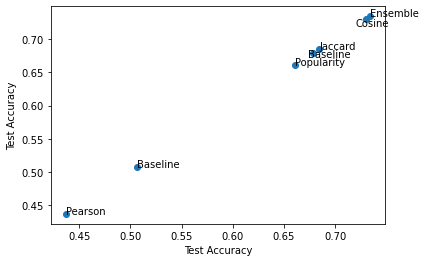

In [60]:
import matplotlib.pyplot as plt

TestAccuracies = [0.5070011668611435,0.6782380396732789,0.6843640606767795, 0.661026837806301,0.7297257876312718, 0.4369894982497083, 0.7342473745624271]
Labels = ["Baseline","Baseline", "Jaccard", "Popularity","Cosine","Pearson","Ensemble"]
LabelPositions = [0.5070011668611435,0.6732380396732789,0.6843640606767795, 0.661026837806301,0.7197257876312718, 0.4369894982497083, 0.7342473745624271]

plt.scatter(TestAccuracies,TestAccuracies)

for i,text in enumerate(Labels):
    plt.annotate(text, (LabelPositions[i],LabelPositions[i]))

plt.ylabel('Test Accuracy')
plt.xlabel('Test Accuracy')
plt.show()

In [62]:
sum(didBuy_training)/len(didBuy_training)

0.5006746407993582

In [63]:
maxItems = -1
maxUserID = ""
minItems = 100000000000000
minitemID = ""
totalItems = 0 
for user in itemsPerUser_Full:
    numItems = len(itemsPerUser_Full[user])
    totalItems += numItems
    if numItems >maxItems:
        maxItems = numItems
        maxUserID = user
    if numItems < minItems:
        minItems = numItems
        minitemID = user
        
print(maxItems,maxUserID,minItems,minitemID,totalItems/len(itemsPerUser_Full))

90 A2V5R832QCSOMX 1 A2P6QV3P7ENWPR 7.351139041633935


In [64]:
maxUsers = -1
maxItemID = ""
minUsers = 100000000000000
minUserID = ""
totalUsers = 0 
for item in usersPerItem_Full:
    numUsers = len(usersPerItem_Full[item])
    totalUsers += numUsers
    if numUsers >maxUsers:
        maxUsers = numUsers
        maxItemID = item
    if numUsers < minUsers:
        minUsers = numUsers
        minUserID = item
        
print(maxUsers,maxItemID,minUsers,minUserID,totalUsers/len(usersPerItem_Full))

440 B0006PLMFQ 1 B0002Y5JEG 17.757115749525617


In [65]:
maxItems = -1
maxUserID = ""
minItems = 100000000000000
minitemID = ""
totalItems = 0 
for user in itemsPerUser:
    numItems = len(itemsPerUser[user])
    totalItems += numItems
    if numItems >maxItems:
        maxItems = numItems
        maxUserID = user
    if numItems < minItems:
        minItems = numItems
        minitemID = user
        
print(maxItems,maxUserID,minItems,minitemID,totalItems/len(itemsPerUser_Full))

156 A2V5R832QCSOMX 3 A221I9R7I92ORO 13.186959937156324


In [66]:
maxUsers = -1
maxItemID = ""
minUsers = 100000000000000
minUserID = ""
totalUsers = 0 
for item in usersPerItem:
    numUsers = len(usersPerItem[item])
    totalUsers += numUsers
    if numUsers >maxUsers:
        maxUsers = numUsers
        maxItemID = item
    if numUsers < minUsers:
        minUsers = numUsers
        minUserID = item
        
print(maxUsers,maxItemID,minUsers,minUserID,totalUsers/len(usersPerItem_Full))

381 B000J4FGAG 10 B00172IEVM 31.853889943074005


In [70]:
modelEnsembleT.coef_

array([[ 7.05309591e-05, -1.83647304e-03,  2.18849751e+00,
         3.10299367e+00]])